*Keep in mind while writing up:*

- *Be concise! Less is more - the fully story is in the source code for those interested.*
- *Be deliberate about: What to highlight in which section (e.g., “this dataset was special due to its high number of variables”…)*
- *Work with visuals and only exceptionally with code. Refer to GitHub, dump code there, the technical people will go there. And (hiring) managers will only read the write-up.*
- *Optimize business value, not model performance! Time/Resource constraints, ….*

### Project Report
# **Preventing Customer Churn with Artificial Neural Networks**
*Disclaimer: This mock project report serves educational purposes only. The data used is public (https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Data). All other company information is fictional. The author has no commercial relationship with mentioned parties.* 
***
### **Executive Summary (max. 7 sentences)**
Situation (1 sentence based on 1.)
<br>
Complication (1 sentence based on 1.)
<br>
Solution (1 sentence based on 2.)
<br>
Recommendations including Solutions' Business Value Add (1-3 sentences based on 3.)
"much buzz around ANN, let's test that here"
***
### **Report Structure**
[Include nice + simple process visualization!]
1. Business Problem Statement
2. Technical Solution
<br>    *2.1. Technical Problem Statement*
<br>    *2.2. Exploratory Data Analysis*
<br>    *2.3. Data Preprocessing*
<br>    *2.4. Feature Selection*
<br>    *2.5. Model Selection (incl. Optimization)*
<br>    *2.6. Final Model Evaluation*
<br>    *2.7. Future Optimization Potentials*
3. Business Recommendations
***

## **1. Business Problem Statement**
For firms like French telecommunication provider Orange, customer retention is critical. This is because retaining customers is much cheaper than the alternative: losing a customer and their revenues plus replacement costs. However, Orange lacks an automated, scalable, and data-driven method for predicting customer churn that would allow Orange to initiate retention measures before customers leave. That is, predicting customer churn currently more or less relies on sporadic guesses. Thus, Orange requested a proof-of-concept for a predictive model that can help identify customers who will likely churn so that retention measures can be initiated. Specifically, encouraged by the enthusiasm surrounding "deep learning", Orange wants the proof-of-concept to explore the potential of this model class.

<br>

## **2. Technical Solution**
#### Main used resources:
- Data: Orange has provided historical customer data (50,000 observations/customers; 230 features) for model optimization, selection, and evaluation. 
- Software: Python 3.8.5., main packages:
    - Pandas, Numpy (for data wrangling)
    - Keras/TensorFlow (for neural network modelling)
    - Scikit-learn (for optimization/gridsearch automation)
    - Matplotlib, Seaborn (for visualization)
- Hardware: standard enduser office notebook (i7-8550U; 4 cores @1.80 GHz)


- for visualization inspirations see here: https://towardsdatascience.com/predict-customer-churn-the-right-way-using-pycaret-8ba6541608ac


### *2.1. Technical Solution: Technical Problem Statement*
The business problem, as put by Orange, is "to predict customer churn". This problem requires translation into a better specified, technical problem before it is solvable using mathematical-statistical methods. Technically put, the problem we solve is to

*maximize the F1-score over the churn predictions of Orange's customers by implementing an artificial neural network with more than one hidden layer and an output layer containing a single neuron with an activation function*.

Each component of this technical problem statement follows from considering the following three issues in light of the business problem we solve: 

#### Specifying the business problem
It is first important to understand that predicting customer churn is, technically, a binary classification problem: given the data available for any particular customer (e.g., age, gender, purchased services, average call duration), we want our model to assign this customer to one of the two classes "churn"/"no churn". Understanding that we solve a classification problem has important implications for two main elements of the technical problem statement:

#### Choosing an adequate model class
In a typical data science project, we would train models from many different model classes (e.g., logistic regression classifiers, trees, support vector machines) and select the best performing models (or combine them in an *ensemble*) for deployment. In this project, however, the client Orange has specified upfront that they want a "deep learning" model, which in more precise technical terms is widely understood as an artificial neural network (ANN) with more than one hidden layer. Further, since we want the ANN's output to always be either "churn" or "no churn", its output layer must contain a single neuron with an activation function (e.g., ReLU, sigmoid) that translates continuous into binary values (1/0).

#### Choosing adequate evaluation metrics
An evaluation metric enables us to assess how "good" a developed model is and optimize it. The perhaps most intuitive metric for a classification model is the *accuracy* of its predictions. Accuracy tells us in which percentage of cases a classification model's predictions ("churn"/"no churn") are true (that is, correctly predict what customers will actually do). However, we can infer from the business context that the classes "churn"/"no churn" we are interested in are *imbalanced*: only a minority of all customers will churn in any given time period. We can thus expect many more customers to be in the "no churn" rather than the "churn" class. Accuracy will thus be a bad metric to optimize: the model could 'cheat' and simply predict "no churn" in 100% of the cases, and never detect a single churning customer, and still have awesome accuracy. In presence of class imbalance, a metric more adequate to optimize is the *F1-score*. A high F1-score indicates not only that the model is able to detect many of those customers who will indeed churn (high *recall*), but also that the model's "churn"-predictions are typically correct (high *precision*).

<br>

### *2.2. Technical Solution: Exploratory Data Analysis (EDA)*
Now that we have specified the technical problem this project should solve, we first familiarize ourselves with the historical customer data Orange has provided. Exploratory data analysis helps us identify how we need to preprocess this data so that the ANN can better learn from it to predict churn. This typically involves some basic overall checks (overall dataset structure, feature types, missing values), but also analyses focused on our target variable, that is, the class label vector "churn"/"no churn" (= what we want to predict).

#### Loading the data
We first load the data from a local drive. X is a matrix containing features and observations, y is a vector containing the class labels we want to predict.

In [34]:
### some settings to increase reproducibility and report readability 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from numpy.random import seed
import tensorflow as tf
seed(3992)
tf.random.set_seed(3992)

import pandas as pd
pd.set_option("float_format", "{:f}".format)
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

### Loading the data
X = pd.read_table('data/orange_small_train.data')
y = pd.read_table('data/orange_small_train_churn.labels', header = None,sep='\t').loc[:, 0].astype('category')

In [35]:
X.shape

(50000, 230)

<br>

#### Inspecting the overall dataset structure

Our very first analytical step is to take a broad look at the overall dataset structure, including the number of features (columns) and observations (rows = customers), feature names, features' data types, categorical features' cardinality, missing value formatting, and some basic descriptive statistics.

In [36]:
X.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.000000,7.000000,NaN,NaN,NaN,NaN,NaN,184.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.000000,580.000000,NaN,14.000000,128.000000,NaN,NaN,166.560000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,3570.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.076907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,35.000000,NaN,1350864.000000,NaN,0.000000,NaN,NaN,7333.110000,NaN,5.000000,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,168.000000,117625.600000,NaN,NaN,NaN,NaN,NaN,1175.000000,NaN,NaN,NaN,6.000000,NaN,720.000000,8.000000,NaN,NaN,NaN,NaN,NaN,0.000000,1212385.000000,69134.000000,NaN,NaN,NaN,NaN,NaN,185.000000,NaN,NaN,0.000000,9.000000,NaN,NaN,NaN,NaN,397579.000000,NaN,NaN,NaN,1812252.000000,NaN,NaN,NaN,NaN,NaN,NaN,142.000000,NaN,NaN,38418.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.000000,NaN,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.000000,210.000000,NaN,2.000000,24.000000,NaN,NaN,353.520000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4764966.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.408032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,26,0.000000,NaN,2872928.000000,NaN,3.000000,NaN,NaN,151098.900000,NaN,25.000000,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58158.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,40.000000,-356411.600000,NaN,NaN,NaN,NaN,NaN,590.000000,NaN,NaN,NaN,72.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,4136430.000000,357038.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,9.000000,NaN,NaN,NaN,NaN,278334.000000,NaN,NaN,NaN,10439160.000000,NaN,NaN,NaN,NaN,NaN,NaN,32.000000,NaN,NaN,238572.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,Na

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 87.7+ MB


In [38]:
X.describe(include='all')

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
count,702.000000,1241.000000,1240.000000,1579.000000,1487.000000,44471.000000,44461.000000,0.000000,702.000000,1487.000000,1240.000000,558.000000,44461.000000,1240.000000,0.000000,1487.000000,1579.000000,1579.000000,1579.000000,0.000000,44471.000000,44991.000000,1487.000000,42770.000000,44991.000000,1487.000000,1487.000000,44989.000000,702.000000,702.000000,0.000000,0.000000,847.000000,1241.000000,44991.000000,1241.000000,1579.000000,44991.000000,0.000000,1241.000000,702.000000,0.000000,1241.000000,44991.000000,344.000000,1241.000000,702.000000,0.000000,1241.000000,702.000000,3747.000000,0.000000,702.000000,1241.000000,0.000000,646.000000,50000.000000,702.000000,820.000000,1487.000000,847.000000,558.000000,694.000000,238.000000,44461.000000,694.000000,1487.000000,1241.000000,1487.000000,1487.000000,1129.000000,27620.000000,50000.000000,44461.000000,1241.000000,44991.000000,702.000000,44991.000000,0.000000,1487.000000,44471.000000,1579.000000,44991.000000,1240.000000,44991.000000,702.000000,702.000000,1083.000000,646.000000,702.000000,1129.000000,171.000000,1487.000000,27620.000000,1241.000000,1241.000000,1487.000000,558.000000,1579.000000,702.000000,873.000000,451.000000,1487.000000,820.000000,820.000000,1579.000000,1487.000000,702.000000,42770.000000,702.000000,1129.000000,44991.000000,50000.000000,1241.000000,820.000000,702.000000,1579.000000,171.000000,44471.000000,1487.000000,702.000000,1241.000000,44991.000000,1579.000000,44461.000000,36080.000000,1083.000000,1083.000000,702.000000,1240.000000,702.000000,44991.000000,44991.000000,44991.000000,1579.000000,694.000000,702.000000,1579.000000,1487.000000,44461.000000,0.000000,702.000000,44991.000000,44471.000000,1579.000000,1487.000000,1487.000000,1487.000000,42770.000000,1579.000000,847.000000,1579.000000,44991.000000,702.000000,1579.000000,694.000000,1129.000000,873.000000,1241.000000,44991.000000,1579.000000,1241.000000,44991.000000,1579.000000,873.000000,1487.000000,0.000000,702.000000,0.000000,1241.000000,1083.000000,1487.000000,44991.000000,1579.000000,0.000000,1240.000000,1241.000000,646.000000,1579.000000,702.000000,44991.000000,1579.000000,1241.000000,1241.000000,0.000000,702.000000,702.000000,1241.000000,21022.000000,333.000000,1083,49631,50000,12784,50000,50000,49857,50000,49996,24592,12783,49999,49857,50000,48066,44471,50000,49857,0.000000,50000,50000,50000,1129,24592,694,50000,49297,49297,44789,50000,50000,50000,44789,820,23856,50000,50000,50000,21568,0.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN

Categorical features' mean cardinality: 1882.0


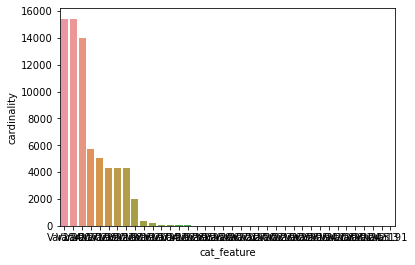

In [39]:
features_cat = list(X.select_dtypes(include=['object']).columns)
temp = X[features_cat]
temp = temp.nunique().sort_values(ascending=False).reset_index()
temp.columns = ['cat_feature', 'cardinality']
import seaborn as sns
ax = sns.barplot(x='cat_feature', y='cardinality', data=temp)
print("Categorical features' mean cardinality:", round(temp['cardinality'].sum()/temp.shape[0],0))

<br>

#### Inspecting missing values

Since we noted that the data contains missing values ("NaN"), we want to know precisely which percentage of values is missing in the data we have been given, and also how these missing values are distributed across features.

In [40]:
round(X.isna().sum().sum()/(X.shape[0]*X.shape[1]), 3)

0.698

<BarContainer object of 230 artists>

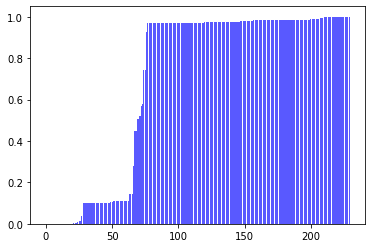

In [41]:
import matplotlib.pyplot as plt
temp = X.isna().sum()/(X.shape[0])
plt.bar(range(len(temp)), sorted(temp), color='blue', alpha=0.65)

#### Checking class balance "churn"/"no churn"

Having acquired an overall impression of the data, we now take a more focused look on our target variable 'Churn', that is, the column containing the class labels our model will need to predict.  

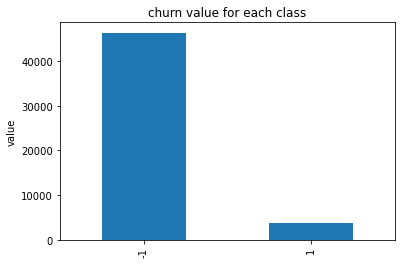

In [42]:
y.value_counts().plot.bar()
plt.ylabel('value')
plt.title('churn value for each class')
plt.show()

In [43]:
y.value_counts()

-1    46328
1      3672
Name: 0, dtype: int64

<br>

#### > EDA key insights:
To summarize, our brief exploratory analysis helped us gain some important insights about the features, observations, and target variable in our data. Going forward, we will need to keep these insights at the back of our mind as they will instruct us how to properly preprocess the data so that our predictive model can learn well from it. Key insight we have gleaned are:

- Features: 
	- Most or all features' scales differ.
	- Orange has anonymized data before providing it (likely to protect customers' privacy).
	- The 230 total features include 38 categorical and 192 numerical features.
	- High cardinality is a big issue in this dataset (on average, 1882 unique values per categorical feature)
- Observations:
	- We have been given data on 50.000 customers and their churn behaviour that we can use for optimizing and evaluating our model.
	- Missing values are another big issue in this dataset (around 70%).
- Target variable:
	- As expected, the two classes in our target variable 'Churn' are heavily imbalanced (around 1 churning customer for 12 non-churning customers).
	- The class labels "churn"/"no churn" are represented by the numerical values 1/-1. 


<br>

### *2.3. Technical Solution: Data Preprocessing*
Before the data can be used for effective model training, it needs to be preprocessed. This is because the ANN model we implement requires data to be in a particular format to effectively learn from the data how to make good predictions. In addition, since preprocessing steps often have interdependencies, being deliberate about their order is important. Otherwise we risk messing up the data used for model training, compromising prediction quality. 

Main preprocessing steps that the key insights gleaned from EDA suggest are the following:
- remove observations and features with all values missing
- replace infrequent categories with a single 'catch-all' category
- create binary indicator columns for missing values
- impute missing values
- encode (= 'make numerical') categorical features
- normalize the features' scales

#### Remove observations and features with all values missing
We first remove any potential observations and features which might not hold any values. These will only push computation times and risk complicating our model without adding anything to its explanatory power.

In [44]:
X.dropna(axis=0, how='all', inplace=True)
X.dropna(axis=1, how='all', inplace=True)

As we can see comparing to above, no observations, but 18 features have been removed:

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 212 entries, Var1 to Var229
dtypes: float64(173), int64(1), object(38)
memory usage: 80.9+ MB


#### Replace infrequent categories with a single catch-all category
EDA has shown that a big issue in the data is the high mean cardinality of categorical features. If there are many different categories, it will be hard for our model to recognize patterns that the model can exploit for predicting customer churn. Thus, to help our model more easily infer useful explanatory patterns, we replace all categories whose frequency of occurrence lies below a cetrain treshold with a single category "RARE_VALUE":

In [46]:
features_cat = list(X.select_dtypes(include=['object']).columns) # update this since we have dropped some features
for feat in features_cat:
    X.loc[X[feat].value_counts(dropna=False)[X[feat]].values < X.shape[0] * 0.02, feat] = 'RARE_VALUE' # replace all categories which occurr in less than 2% of observatiosn

As indicated by the following fraction of cells in which categories have been replaced, this preprocessing step will have a significant impact on our later model:

In [47]:
X[X == 'RARE_VALUE'].count().sum()/(X.shape[0]*X.shape[1])

0.048098962264150946

#### Putting aside some test data
Before we proceed with the next preprocessing steps, we put aside some test data. The idea behing putting aside test data is essentially to pretend that we would possess some of the new/unseen data that will actually be only coming in after our model will have been deployed (= in actual use, or 'production'). This trick allows us to get an idea about how good our model would perform 'out in the wild'.
<br>
<br>
However, the need to put aside test data also introduces additional complexity into preprocessing: For preprocessing steps whose parameters depend on the data they are applied to (e.g., scaling, encoding), we have to act like we would not have the test data available. This means we need to first preprocess the training data, and then the test data separately in the exact same way. Not doing this and having the test data still 'in' during data-dependent preprocessing steps would allow our model to learn from information that the model could, conceptually speaking, impossibly have access to. This is called 'peeking' or 'data leakage'. Data leakage risks leading our evaluation metrics to tell us that we have built a good model, but then after deployment find out that we have actually built a bad model - that is, when time and money have already been wasted.
<br>
<br>
There is yet another issue we need to account for when putting aside test data: the class imbalance in our data that our EDA has confirmed. Usually, we would simply randomly split test and training data. However, since we need the training and test data to reflect the dataset's class distribution ("churn"/"no churn"), we perform a *stratified* split, that is, a split replicating the dataset's class distribution to both the created training and test subsets:

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3992)

#### Adding missing value indicator features
We now return once more to the issue of missing values. Since the number of missing values in the data is so high, we want to think some more about how we might exploit that. While a missing value represents an absence of information, the very fact per se that a value is missing might indicate something (e.g., a customer not booking a particular service) and possess predictive power. Thus, for each feature with missing values, we create an additional feature which indicates via the values 1 or 0 for each observation the presence or absence of a missing value.

In [49]:
import numpy as np
for clm in X_train:
    if X_train[clm].isna().sum() > 0:
        X_train.insert(X_train.shape[1], f"{clm}_NaNInd", 0)
        X_train[f"{clm}_NaNInd"] = np.where(pd.isnull(X_train[clm]), 1, 0)

As we can see, 185 binary variables have beend added to our training data, resulting in 397 variables:

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 23498 to 19306
Columns: 397 entries, Var1 to Var229_NaNInd
dtypes: float64(173), int32(185), int64(1), object(38)
memory usage: 93.2+ MB


#### Imputing missing values
To add at least some meaningful information to the data where values are missing, we impute missing values in numerical features with column-wise means, and missing values in categorical features with the category 'unknown'.

In [51]:
from sklearn.impute import SimpleImputer
features_num_train = list(X_train.select_dtypes(include=['float']).columns)
imputer_nums = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train[features_num_train] = imputer_nums.fit_transform(X_train[features_num_train])

features_cat_train = list(X_train.select_dtypes(include=['object']).columns)
imputer_cats = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')
X_train[features_cat_train] = imputer_cats.fit_transform(X_train[features_cat_train])

As we can see, our data now does not contain any missing values anymore:

In [52]:
round(X_train.isna().sum().sum()/(X_train.shape[0]*X.shape[1]), 3) #returns the percentage of missing values in the training data

0.0

#### Encoding categorical features
We have also learned during EDA that there are quite some categorical features. Our ANN model (like many other model classes), however, can only handle numerical inputs. We thus *one-hot encode* (OHE) the categorical features. This means that for each unique value in each categorical feature, we create an additional feature which indicates via the values 1 or 0 for each observation the presence or absence of that unqiue value. We drop the original features and only keep the one-hot encoded features.

In [53]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
enc = make_column_transformer((OneHotEncoder(max_categories=20, handle_unknown='ignore'), features_cat_train), remainder='passthrough')
transformed = enc.fit_transform(X_train)
enc_df = pd.DataFrame(transformed, columns=enc.get_feature_names())
cols = enc_df.columns.tolist()
cols = cols[168:] + cols[:168]
X_train = enc_df[cols]

As we can see, OHE has added 130 dummy variables to our training data, resulting in 527 variables:

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 527 entries, Var1 to onehotencoder__x37_unknown
dtypes: float64(527)
memory usage: 160.8 MB


#### Rescale features
Finally, we rescale the features. We have seen in EDA that the features were measured using different scales. To rule out that this could affect our model, we remove from all features (except the indicator columns we added) the dataset mean and scale the feature to unit variance:

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[features_num_train] = scaler.fit_transform(X_train[features_num_train])

Confirm that scaling has happened properly:

In [56]:
X_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,Var12,Var13,Var14,Var16,Var17,Var18,Var19,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var33,Var34,Var35,Var36,Var37,Var38,Var40,Var41,Var43,Var44,Var45,Var46,Var47,Var49,Var50,Var51,Var53,Var54,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var168,Var170,Var171,Var172,Var173,Var174,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var186,Var187,Var188,Var189,Var190,Var1_NaNInd,Var2_NaNInd,Var3_NaNInd,Var4_NaNInd,Var5_NaNInd,Var6_NaNInd,Var7_NaNInd,Var9_NaNInd,Var10_NaNInd,Var11_NaNInd,Var12_NaNInd,Var13_NaNInd,Var14_NaNInd,Var16_NaNInd,Var17_NaNInd,Var18_NaNInd,Var19_NaNInd,Var21_NaNInd,Var22_NaNInd,Var23_NaNInd,Var24_NaNInd,Var25_NaNInd,Var26_NaNInd,Var27_NaNInd,Var28_NaNInd,Var29_NaNInd,Var30_NaNInd,Var33_NaNInd,Var34_NaNInd,Var35_NaNInd,Var36_NaNInd,Var37_NaNInd,Var38_NaNInd,Var40_NaNInd,Var41_NaNInd,Var43_NaNInd,Var44_NaNInd,Var45_NaNInd,Var46_NaNInd,Var47_NaNInd,Var49_NaNInd,Var50_NaNInd,Var51_NaNInd,Var53_NaNInd,Var54_NaNInd,Var56_NaNInd,Var58_NaNInd,Var59_NaNInd,Var60_NaNInd,Var61_NaNInd,Var62_NaNInd,Var63_NaNInd,Var64_NaNInd,Var65_NaNInd,Var66_NaNInd,Var67_NaNInd,Var68_NaNInd,Var69_NaNInd,Var70_NaNInd,Var71_NaNInd,Var72_NaNInd,Var74_NaNInd,Var75_NaNInd,Var76_NaNInd,Var77_NaNInd,Var78_NaNInd,Var80_NaNInd,Var81_NaNInd,Var82_NaNInd,Var83_NaNInd,Var84_NaNInd,Var85_NaNInd,Var86_NaNInd,Var87_NaNInd,Var88_NaNInd,Var89_NaNInd,Var90_NaNInd,Var91_NaNInd,Var92_NaNInd,Var93_NaNInd,Var94_NaNInd,Var95_NaNInd,Var96_NaNInd,Var97_NaNInd,Var98_NaNInd,Var99_NaNInd,Var100_NaNInd,Var101_NaNInd,Var102_NaNInd,Var103_NaNInd,Var104_NaNInd,Var105_NaNInd,Var106_NaNInd,Var107_NaNInd,Var108_NaNInd,Var109_NaNInd,Var110_NaNInd,Var111_NaNInd,Var112_NaNInd,Var114_NaNInd,Var115_NaNInd,Var116_NaNInd,Var117_NaNInd,Var118_NaNInd,Var119_NaNInd,Var120_NaNInd,Var121_NaNInd,Var122_NaNInd,Var123_NaNInd,Var124_NaNInd,Var125_NaNInd,Var126_NaNInd,Var127_NaNInd,Var128_NaNInd,Var129_NaNInd,Var130_NaNInd,Var131_NaNInd,Var132_NaNInd,Var133_NaNInd,Var134_NaNInd,Var135_NaNInd,Var136_NaNInd,Var137_NaNInd,Var138_NaNInd,Var139_NaNInd,Var140_NaNInd,Var142_NaNInd,Var143_NaNInd,Var144_NaNInd,Var145_NaNInd,Var146_NaNInd,Var147_NaNInd,Var148_NaNInd,Var149_NaNInd,Var150_NaNInd,Var151_NaNInd,Var152_NaNInd,Var153_NaNInd,Var154_NaNInd,Var155_NaNInd,Var156_NaNInd,Var157_NaNInd,Var158_NaNInd,Var159_NaNInd,Var160_NaNInd,Var161_NaNInd,Var162_NaNInd,Var163_NaNInd,Var164_NaNInd,Var165_NaNInd,Var166_NaNInd,Var168_NaNInd,Var170_NaNInd,Var171_NaNInd,Var172_NaNInd,Var173_NaNInd,Var174_NaNInd,Var176_NaNInd,Var177_NaNInd,Var178_NaNInd,Var179_NaNInd,Var180_NaNInd,Var181_NaNInd,Var182_NaNInd,Var183_NaNInd,Var184_NaNInd,Var186_NaNInd,Var187_NaNInd,Var188_NaNInd,Var189_NaNInd,Var190_NaNInd,Var191_NaNInd,Var194_NaNInd,Var200_NaNInd,Var201_NaNInd,Var205_NaNInd,Var206_NaNInd,Var213_NaNInd,Var214_NaNInd,Var215_NaNInd,Var219_NaNInd,Var223_NaNInd,Var224_NaNInd,Var225_NaNInd,Var229_NaNInd,onehotencoder__x0_r__I,onehotencoder__x0_unknown,onehotencoder__x1_RARE_VALUE,onehotencoder__x2_2Knk1KF,onehotencoder__x2_AERks4l,onehotencoder__x2_RARE_VALUE,onehotencoder__x2_RO12,onehotencoder__x3_RARE_VALUE,onehotencoder__x3_SEuy,onehotencoder__x3_unknown,onehotencoder__x4_RARE_VALUE,onehotencoder__x4_taul,onehotencoder__x5_1K8T,onehotencoder__x5_RARE_VALUE,onehotencoder__x6

#### Transforming class labels
We finally bring the class labels into a more suitable form:

In [57]:
y_train.replace(-1, 0, inplace=True)
y_train.value_counts()

0    37062
1     2938
Name: 0, dtype: int64

#### Test set preprocessing
We now apply the same preprocessing steps, in the same order, with the same parameters, to the test data:

In [58]:
# insert NaN indicator columns
for clm in X_test:
    if X_test[clm].isna().sum() > 0:
        X_test.insert(X_test.shape[1], f"{clm}_NaNInd", 0)
        X_test[f"{clm}_NaNInd"] = np.where(pd.isnull(X_test[clm]), 1, 0)

# missing value imputation: apply imputers that have been fit to training data
X_test[features_num_train] = imputer_nums.transform(X_test[features_num_train])
X_test[features_cat_train] = imputer_cats.transform(X_test[features_cat_train])
X_test.isna().sum().sum()

# Encode categorical features
transformed = enc.transform(X_test)
enc_df = pd.DataFrame(transformed, columns=enc.get_feature_names())
cols = enc_df.columns.tolist()
cols = cols[168:] + cols[:168]
X_test = enc_df[cols]

# apply scaler that has been fit to training data
X_test[features_num_train] = scaler.transform(X_test[features_num_train])

# transform target variable
y_test.replace(-1, 0, inplace=True)

We complete preprocessing by ensuring that the preprocessed training and test datasets have the same 527 features, in the same order:

In [59]:
print('Percentage of identical columns:', sum(X_train.columns == X_test.columns)/len(X_train.columns)*100)

Percentage of identical columns: 100.0


### *2.5. Technical Solution: Feature Selection*

While we have now preprocessed our data, the number of features is very high. In other words, our data is high-dimensional. This is undesirable for a variety of reasons, among the most important ones computational overhead and increased overfitting risk (see *curse of dimensionality*). Generally speaking, we want predictive models to use all the features with the most predictive power, but also as few features as possible. Thus, before we move on to building our ANN model, we train a random forest classifier model from which we can extract those features which have helped the forest model to best split observations into churning and non-churning customers.
<br>
<br>
We first split our training data into a training and a cross-validation dataset for feature selection:

In [60]:
X_train_fs, X_cv_fs, y_train_fs, y_cv_fs = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=3992)

To make sure that we do not select features based on an extremely bad random forest model, we optimize the model a little. Specifically, we grow multiple forest models with different numbers of trees, and with different maximum depths: 

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [28]:
random_classifier = RandomForestClassifier()
parameters = {'max_depth':np.arange(3,10),'n_estimators':list(range(25,251,25))}
random_grid = GridSearchCV(random_classifier, parameters, cv=3)
random_grid.fit(X_cv_fs, y_cv_fs)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200,
                                          225, 250]})

Comparing all forest models that we have grown, it turns out that the following parameters create the best random forest classifier:

In [29]:
print("Optimal Forest Hyperparams:", random_grid.best_params_)

Optimal Forest Hyperparams: {'max_depth': 3, 'n_estimators': 25}


We compile a random forest classifier with the identified optimum parameters and train it on the training data for feature selection:

In [62]:
rf_model = RandomForestClassifier(
    n_estimators=25,
    max_depth=3,
    max_features=None,
    max_leaf_nodes=None,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight='balanced',
    random_state=3992,
    verbose=0,
    warm_start=False)

rf_model.fit(X=X_train_fs, y=y_train_fs)

c:\Users\marc.feldmann\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None,
                       n_estimators=25, n_jobs=-1, oob_score=True,
                       random_state=3992)

Now we can extract and visualize from this optimized forest model the features that most helped the model tell apart churning and non-churning customers:

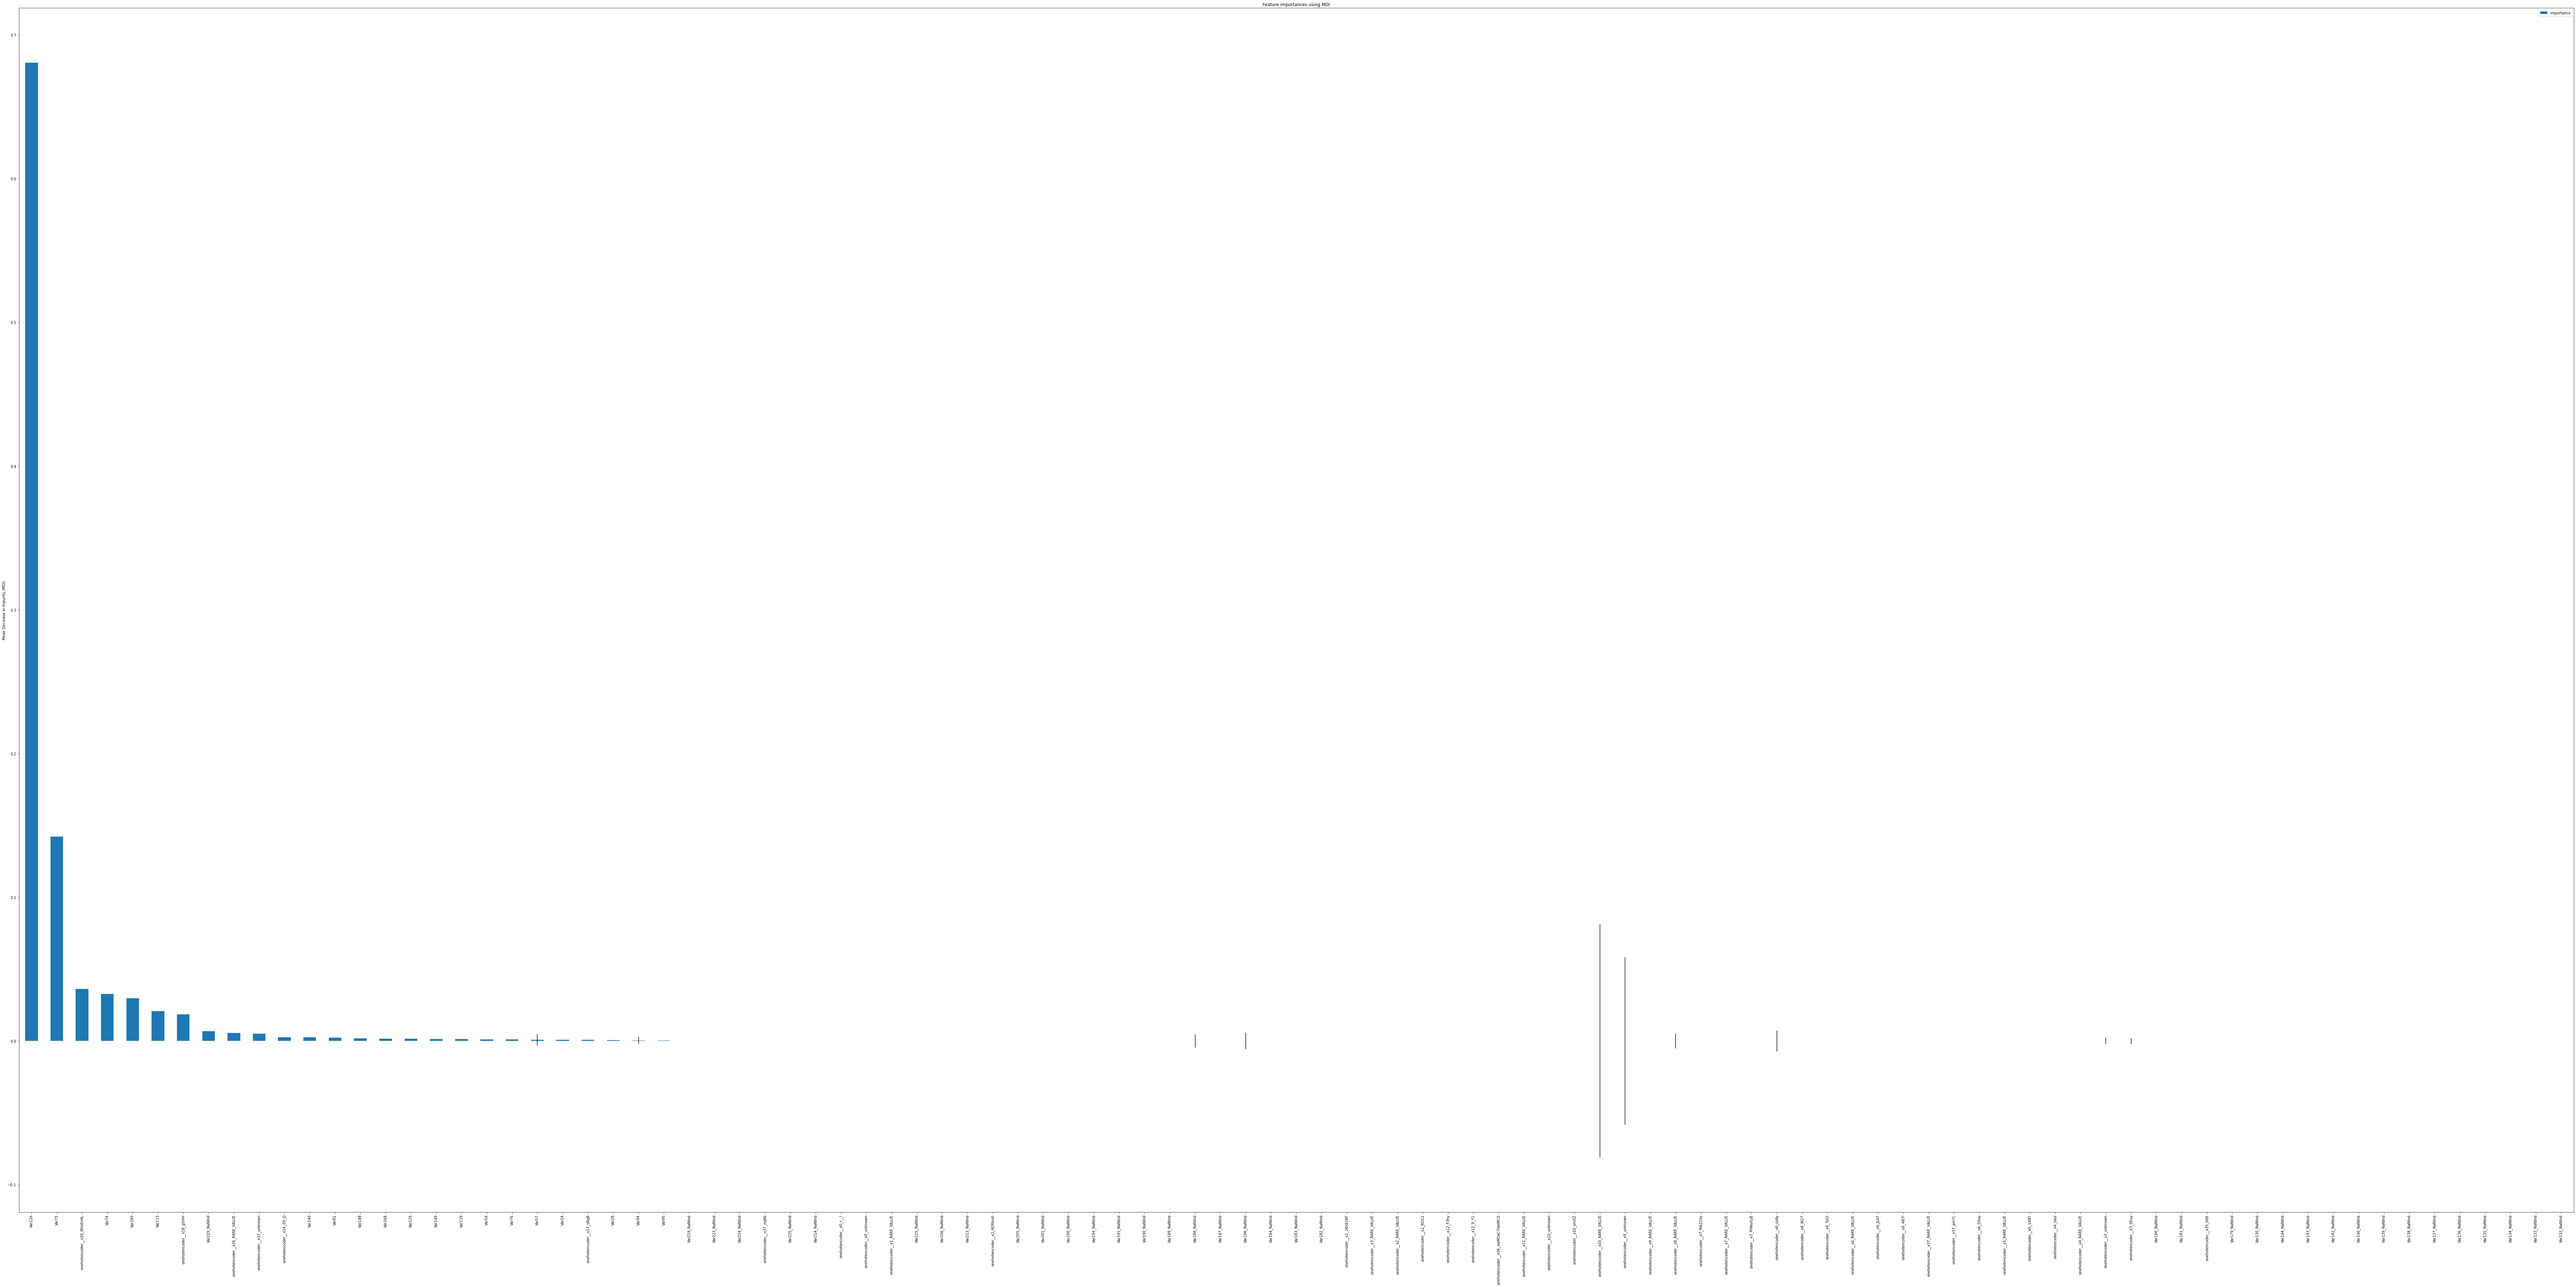

In [68]:
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# feature importance plot
std = np.std([rf_model.feature_importances_[:101] for rf_model in rf_model.estimators_], axis=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
feature_importances[:101].plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean Decrease in Impurity (MDI)")
fig.tight_layout()

As we can see, only a very small number of the more than 500 features is actually helpful for predicting customer churn. Using only these features will save A LOT of computation time during ANN training, and also greatly reduce ANN complexity, without losing prediction quality. More simply put, feature selection has helped us make better predictions MUCH less costly. We thus throw all features but the most important ones from the training and test data that we use for ANN training and evaluation:

In [69]:
most_imp_feats = feature_importances[:26].index.to_list()
X_train = X_train[most_imp_feats]
X_test = X_test[most_imp_feats]

### *2.4. Technical Solution: Model Selection (incl. Optimization)*

Now that we have preprocessed our data and identified the most important features, we use the data for building and optimizing an artificial neural network classification model. Here, we will benefit from having spelled out earlier the technical problem we solve (*maximize the F1-score over the churn predictions of Orange's customers by implementing an artificial neural network with more than one hidden layer and an output layer containing a single neuron with an activation function*). This statement will guide us in the following steps: defining an optimization strategy, defining the ANN's architecture, optimization, and final model training.


#### Define model optimization strategy
The reason for defining a model optimization strategy is simple: resources are limited, but the number of possible models is infinite (literally). This is due to the typically high number of optimizable parameters, and the infinite ranges of possible values for several of these parameters. This implies that simply jumping into optimization will likely make one end up endlessly tune everything and anything. Generally speaking, while model optimization strategies should be tailored to data science projects case-by-case, formulating them always requires a thorough understanding of the project's stakeholder expectations, the problem to be solved, the model classes used, and the resources available.
<br>
<br>
For the prediction of churn among Orange's customers, we will focus our optimization strategy on four basic elements:
- (1) the evaluation metric
- (2) the optimization metric
- (3) the optimized hyperparameters, and
- (4) the optimization procedure. 

(1) _Evaluation metric_: F1-score.
<br>
We use this metric to identify which model among all trained models best solves our problem. We have explained our choice of the F1-score in 2.1. We also pull some further metrics from Keras' metrics library to enable a more comprehensive assessment of the trained models.

In [70]:
import sklearn.metrics
scoring = {
    "F1": sklearn.metrics.make_scorer(sklearn.metrics.f1_score),
    "Accuracy": sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score),
    "Recall": sklearn.metrics.make_scorer(sklearn.metrics.recall_score),
    "Precision": sklearn.metrics.make_scorer(sklearn.metrics.precision_score)
}

(2) _Optimization metric_: Binary cross-entropy loss.
<br>
We use this metric to allow the model to "learn", that is, adjust its coefficients ('weights') during training. Binary cross-entropy is a default optimization metric for binary classification problems, and there is no obvious reason to deviate. (Implementation: see step "Define artificial neural network architecture".)

(3) _Optimized Parameters_:
<br>
We will optimize the following parameters. These are also called "hyper"parameters to distinguish them from model-specific parameters such as coefficients. To be able to optimite these parameters, we will have to include them in the ANN's architecture (see step "Define artificial neural network architecture").

| param name | explanation |
| --- | --- |
| batch_size | Controls how many observations are propagated through the network before coefficients are updated |
| deep | Controls whether network is 'shallow' (1 hidden layer) or 'deep' (> 1 hidden layer) |
| neurons | Controls number of nodes on network layers |
| learning_rate | Controls how strongly coefficients are updated  |
| dropout_rate | Controls fraction of layer inputs which will be randomly ignored in updating |
| kernel_initializer | Controls the distribution from which the ANN's initial random coefficients are drawn |

(4) _Optimization procedure_: Staged grid search with class-weighted, k-fold cross-validation.
<br>
- "Staged grid search": This means we define some values for each optimized hyperparameter, and exhaustively search through the resulting parameter "grid". For each grid node, a model using this grid node's parameter value combination will be trained on k training subsets (using the optimization metric) and evaluated on k validation subsets of the training data (using the evaluation metric). We run two grid search, optimizing the ANN architecture in the first and the hyperparameters in the second.
- "Class weighted": To account for class imbalance, weights will be assigned to classes during training to penalize misclassification of the two different classes to different degrees (we unsuccessfully tried SMOTETomek resampling as an alternative).
- "cross-validation": The purpose of validation sets is to have an indication how well a trained model would generalize to unseen data after deployment (similar to the train/test-split logic described above).
- "k-fold": The k folds allow to compute the evaluation metric as a mean, and thus make model evaluation more robust against bias resulting from random validation set sampling. (Implementation: see step "Optimization".)

#### Define artificial neural network architecture
For the "deep learning" proof-of-concept requested by Orange, we choose a simple "feedforward" (as opposed to, e.g., recurrent or convolutional) neural net architecture. In essence, feedforward here means that the outputs of neurons on one network layer are sent ("fed forward") only to neurons of subsequent layers (instead of the same or previous layers). Further, to probe into the potential of "deep" versus "shallow" learning, we variabilize the number of hidden layers.

In [71]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.constraints import maxnorm
from keras.regularizers import l2
from keras.layers import GaussianNoise
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Sequential
import keras.metrics
from sklearn.utils.class_weight import compute_class_weight

def create_model(learning_rate=0.001, dropout_rate=0.0, deep='n', neurons=X_train.shape[1], kernel_initializer='glorot_uniform'):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout_rate))
    if deep == "y":
        model.add(Dense(round(neurons**(1/1.2), 0), activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer))
        model.add(Dropout(dropout_rate))
        model.add(Dense(round(neurons**(1/1.5), 0), activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name='ROC_AUC'),
            "accuracy",
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall")
        ]
    )
    return model

model = KerasClassifier(build_fn=create_model, verbose=2) #this wrapper allows us to feed the Keras model into Sklearn's GridSearchCV class

#### Optimization
We now turn to the actual model optimization. Hereto, we first compile the optimization procedure we had defined as part of our optimization strategy. (The following code will run only grid search 2 and here use the optimal parameters that have been found during grid search 1).

In [72]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

grid_name = "hyparam_grid_"

if grid_name == "arch_grid_": #we first tune the ANN architecture...
    param_grid = dict(
        epochs=[5],
        batch_size=[128],
        deep=['n', 'y'],
        neurons=[
            round(X_train.shape[1]**(1/1.5), 0),
            round(X_train.shape[1]/2, 0),
            X_train.shape[1],
            round(X_train.shape[1]*2, 0),
            round(X_train.shape[1]**(1.5), 0),
            round(X_train.shape[1]**(1.6), 0),
            round(X_train.shape[1]**(1.7), 0),
            round(X_train.shape[1]**(1.8), 0),
            round(X_train.shape[1]**(1.9), 0),
            round(X_train.shape[1]**(2), 0),
            round(X_train.shape[1]**(2.1), 0),
            round(X_train.shape[1]**(2.2), 0)]
    )
elif grid_name == "hyparam_grid_": #...and then the hyperparameters
    param_grid = dict(
        epochs=[5],
        batch_size=[64, 128, 256, 512, 1024],
        deep=['y'],
        neurons=[round(X_train.shape[1]**(2.2), 0)],
        learning_rate=[0.0001, 0.001, 0.01],
        dropout_rate=[0.0, 0.45, 0.9],
        kernel_initializer=['glorot_uniform', 'he_uniform', 'he_normal']
    )

model = KerasClassifier(build_fn=create_model, verbose=2) #this wrapper allows us to feed the Keras model into Sklearn's GridSearchCV class

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    verbose=3,
    refit='F1',
    n_jobs=2,
    scoring=scoring,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True),
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.values),
    y=y_train.values.reshape(-1),
)
class_weights = dict(zip(np.unique(y_train.values), class_weights))

C:\Users\MARC~1.FEL\AppData\Local\Temp/ipykernel_20508/3315219488.py:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=2) #this wrapper allows us to feed the Keras model into Sklearn's GridSearchCV class


All now left to do in optimization is fit the grid search model to our training data:

In [73]:
grid_result = grid.fit(
    X_train,
    y_train,
    class_weight=class_weights)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


#### Model selection
As a basis for model selection, we store the grid search's results to a dataframe:

In [167]:
results = pd.DataFrame(grid_result.cv_results_["params"])
results["means_val_F1"] = grid_result.cv_results_["mean_test_F1"]
results['means_val_ROC_AUC'] = grid_result.cv_results_['mean_test_ROC_AUC']
results["means_val_Accuracy"] = grid_result.cv_results_["mean_test_Accuracy"]
results["means_val_Recall"] = grid_result.cv_results_["mean_test_Recall"]
results["means_val_Precision"] = grid_result.cv_results_["mean_test_Precision"]
results["means_train_F1"] = grid_result.cv_results_["mean_train_F1"]
results['means_train_ROC_AUC'] = grid_result.cv_results_['mean_train_ROC_AUC']
results["means_train_Accuracy"] = grid_result.cv_results_["mean_train_Accuracy"]
results["means_train_Recall"] = grid_result.cv_results_["mean_train_Recall"]
results["means_train_Precision"] = grid_result.cv_results_["mean_train_Precision"]

from datetime import datetime
import openpyxl
path = "C:\\Users\\marc.feldmann\\Documents\\data_science_local\\CustomerChurnPrediction\\results\\hyparam_opt\\"
filename = (path + "FNN_clf_GSresults_" + grid_name + datetime.now().strftime("%d_%m_%Y__%H_%M_%S") + ".xlsx")
results.to_excel(filename)


In tabular form, the grid search results look like the following. Each row represents one of the models trained during grid search.

In [168]:
# results = pd.read_excel("C:\\Users\\marc.feldmann\\Documents\\data_science_local\\CustomerChurnPrediction\\results\\hyparam_opt\\FNN_clf_GSresults_param_bundle3_grid_09_08_2022__21_38_02.xlsx")
results.sort_values('means_val_Recall', ascending=False)

,batch_size,beta_1,beta_2,deep,dropout_rate,epochs,learning_rate,neurons,noise,reg,weight_constraint,means_val_F1,means_val_Accuracy,means_val_Recall,means_val_Precision,means_train_F1,means_train_Accuracy,means_train_Recall,means_train_Precision
0,128,0.990000,0.999000,y,0.000000,10,0.000100,264.000000,0.000100,0.250000,0.100000,0.045603,0.642168,0.333333,0.024476,0.045623,0.642191,0.333333,0.024487


(add later here: visualization of some interesting grid search results, including deep learning y/n)
nod to: model diagnosis: learning curves (train [how well model learns], val [how well model generalizes to new data]) > show that I can interpret and draw conclusions from that

#### Final model training
Wenow train the final model, using the identified optimal parameters (i.e., those that optimize F1 on the validation data). We do this time on the entire training data instead of subsets such as in CV to leverage all available data for learning.

In [ ]:
# optimum params:
epochs=5
batch_size=1024
neurons=round(X_train.shape[1]**(1.9), 0)
learning_rate=0.001
dropout_rate=0.0
kernel_initializer='glorot_uniform'

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer))
model.add(Dropout(dropout_rate))
model.add(Dense(round(neurons**(1/1.2), 0), activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer))
model.add(Dropout(dropout_rate))
model.add(Dense(round(neurons**(1/1.5), 0), activation='relu', input_dim=X_train.shape[1], kernel_initializer=kernel_initializer))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name='ROC_AUC'),
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    class_weight=class_weights
)

### *2.5. Technical Solution: Final Model Evaluation*
Model Evaluation on 'Unseen' Data (simulate by priorly held out 'Test Data')
- Do the results make sense?


Result interpretation
- in write-up: reflect on fact neural networks / deep learning seem to be overhyped
- see e.g.: Peter Roßbach: "Neural Networks vs. Random Forests – Does it always have to be Deep Learning?
- - make that explicit point of the write-up! "test" that!
- show here that I know how to work with learning curves

when looking at results, come back to earlier point, explain via clas imbalance
come back to earlier point: 
- make it one main technical point in the article that high accuracy can be misleading (when? why?) - have to also check other measures
- - includein write-up my reflections for using precision/recall instead of AUC (argue by importance to detect minority class relative to importance of TPs and FPs) (expl in simple language)

- show/compare how accuracy can be misleading


- feature importance chart

In [ ]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['churn'])
print("ROC-AUC score is {}".format(sklearn.metrics.roc_auc_score(y_test, y_pred)))

precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, y_pred)
auc = sklearn.metrics.auc(recall, precision)
from matplotlib import pyplot
# no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(0.0778, 0.0823, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green", label='Churn Informed Guessing')
# plt.plot([0.4286, 0.4286], [0.375, 0.375], linestyle='--', label='Churn Random Guessing')
plt.plot(recall, precision, marker='.', label='ANN Churn Predictor')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

### *2.6. Technical Solution: Future Optimization Potentials*
(hier sammeln alles ich zeitlich nicht geschafft hab, aber für wichtig halte - um Kritik zu preempten)

Schema: Potential - Umsetzungsaufwand - erwarteter Umsetzungseffekt auf Business Metric

- version 2: optimization potentials (versus v1) to explore ceteris paribus:
- perform infrequent category replacement for test and train sets separately 
- not explored/limitations: only individually optimized, due to constraints in processing power and time, optimization dependencies between variables neglected
- only narrow ranges in gridsearch covered, so sound change that only found local optima per parameter
- potential: NaN imputation with means on subsets of rows: one could search powerful clustering criteria first and than impute cluster means
- also: was using smaller dataset, large dataset with many more variables may allow to increase a classifier's precision/recall
- Make sure to also compare to others' results - I seem to be already working at the upper boundary of what's possible on this dataset with ANNs!
- optimization potential: in practice, one would normally traing many different models and select/stack the best; show somehow that I'm aware of that
- (optimization potential: add and compare AUC: simple logistic regression, random forest, 'flat' neural network, XGBoost)
- optimization potential: put data into an AWS instance and run there
- multicollinearity - check whether an issue - we want to have model as simple as possible! will decrease risk of overfitting that ANNs are especially prone to
- outliers: Scaler Min Max or Robust made no big difference (see model_comparision Excel), suggesting it is not problematic that we have not removed outliers in data preprocessing; still might contain some potential to increase model performance
- feature selection: have touched (selectKBest), but not exhausted feature selection 
- feature engineering: dimensionality reduction to reduce dimensionality, create new and more 'powerful' features; kurz auf curse of dimensionality eingehen und auf ANNs overviffting tendency; feature selection would have benefit to be explanable however, features anonymized anyways
- optimization: "Optimization of only thought about in terms of tuning hyperparamters; but also preprocessing includes many steps that can be done in different ways - meaning also has potential to optimize: read following in conjunction with "diary" to see what I have optimzied here and with which success: <br>
- code cleaning: to increase code reusability and readability, repetitive parts could be wrapped into functions and moved into separate script (e.g., preprocessing steps applied both to training and test data)
- clarify optimization approach: first optimized preprocessing (experiemented eg. with X instead of Y) - resulted in above described procedure; now: hyperparameter tuning:
- optimize network architecture, e.g. LSTM, see "neural network zoo"

## **3. Business Recommendations**
"What do the generated insights/model urge us/allow us to do different next Monday, and which value (business metric!) will that generate?"

direkt aus auftrag (1.) ableiten. incl.:
- (after implementing comparative models:) "turns out, deep learning (might) not be best for this kind of problem; best practice computer vision, very large datasets; here: tree model such as XGboost or simple logistic regression better 
- based on a feature importance chart for final ANN, identify potential churn drivers: discuss how can be made visible and influenced by which staff groups XY (account managers? service managers?); measure, enable and encourage these staff groups to act on identified drivers  

Good Example: https://www.kaggle.com/code/hamzaben/employee-churn-model-w-strategic-retention-plan/notebook